# Class overlap: continuation

This notebook's goal is to extend the methods initiated in 

1. Build-up of a more automatic approach
2. Validation of the method
3. Generalization to unseen data
4. Extension to unseen data

In [44]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.cluster import KMeans
from scipy.spatial.distance import squareform
from mpl_toolkits.mplot3d import Axes3D
import gower
import prince
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import f1_score, make_scorer, confusion_matrix, recall_score, roc_auc_score, roc_curve, average_precision_score
from sklearn.linear_model import LogisticRegression
from collections import Counter
from typing import List
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbPipeline
from tqdm import tqdm
from scipy.spatial.distance import euclidean, hamming
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import BallTree
from sklearn.neighbors import KernelDensity
from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors


# import from custom package
from auxFuns.EDA import *
from auxFuns.modelling import *
from auxFuns.class_overlap import *

In [43]:
import auxFuns.EDA 
importlib.reload(auxFuns.EDA)

import auxFuns.modelling
importlib.reload(auxFuns.modelling)

import auxFuns.class_overlap
importlib.reload(auxFuns.class_overlap)

<module 'auxFuns.class_overlap' from 'c:\\Users\\angel\\Documents\\VSCode\\rsv_modelling_transfer_learning\\auxFuns\\class_overlap.py'>

In [3]:
# Load of the data and filter in the needed features

raw_datasets_path = os.getcwd() + '/datasets/raw'
processed_datasets_path = os.getcwd() + '/datasets/processed'

rsv_predictors_df_v2 = pd.read_csv(processed_datasets_path + '/rsv_predictors_phase1_daysDedup_seasons_prevTest_v2.csv',low_memory=False)
rsv_predictors_df_v2 = make_it_categorical_v2(rsv_predictors_df_v2)

In [6]:
selected_features = ['sex', 'marital_status', 'race','patient_regional_location', 'age_group',
                     'Acute_upper_respiratory_infection','Influenza','Pneumonia','Bronchitis','Symptoms_and_signs__digestive_system_and_abdomen','General_symptoms_and_signs','any_symptom',
                     'COPD','AIDS','Asthma_chronic','CCI',
                     'sine','cosine','calendar_year', 
                     'healthcare_seeking', 'influenza_vaccine',
                     'n_symptoms','prev_positive_rsv','previous_test_daydiff','n_immunodeficiencies', 
                     'tumor_indicator','tumor_last_year',
                     'season',
                     'n_tests_that_day']
selected_features_v1 = ['n_tests_that_day', 'sine','cosine', 'previous_test_daydiff',
                     'Bronchitis', 'CCI',
                     'Acute_upper_respiratory_infection', 'n_immunodeficiencies', 'n_symptoms',
                     'healthcare_seeking', 
                     'General_symptoms_and_signs', 'prev_positive_rsv', 'Influenza',
                     'season','multiple_tests']
selected_features_v2 = ['n_tests_that_day', 'sine','cosine', 'previous_test_daydiff',
                     'Bronchitis', 'CCI',
                     'Acute_upper_respiratory_infection', 'n_immunodeficiencies', 'n_symptoms',
                     'healthcare_seeking', 
                     'General_symptoms_and_signs', 'prev_positive_rsv', 'Influenza',
                     'key_comorbidities','Pneumonia',
                     'season','month_of_the_test','multiple_tests',
                     'BPA','BPAI']
selected_features_v3 = selected_features_v2 + ['race', 'age_group','marital_status','sex',
                                                    'patient_regional_location','calendar_year']

selected_features_v1.append('RSV_test_result')
selected_features_v2.append('RSV_test_result')
selected_features_v3.append('RSV_test_result')

In [7]:
df1 = rsv_predictors_df_v2[selected_features_v2]

df1.shape, df1.columns

((86058, 21),
 Index(['n_tests_that_day', 'sine', 'cosine', 'previous_test_daydiff',
        'Bronchitis', 'CCI', 'Acute_upper_respiratory_infection',
        'n_immunodeficiencies', 'n_symptoms', 'healthcare_seeking',
        'General_symptoms_and_signs', 'prev_positive_rsv', 'Influenza',
        'key_comorbidities', 'Pneumonia', 'season', 'month_of_the_test',
        'multiple_tests', 'BPA', 'BPAI', 'RSV_test_result'],
       dtype='object'))

# 0. Build up on an initial dataframe for visualization purposes

In [8]:
random_seed = 42
n_components = 5

X_all = df1.drop(['RSV_test_result'], axis = 1)

famd = prince.FAMD(n_components=n_components, random_state=random_seed)
famd = famd.fit(X_all)

df5_visualization = famd.transform(X_all)

# Ensure both df1 and df5_visualization present the same records in the same order
df1 = df1.sort_index()
df5_visualization = df5_visualization.sort_index()

assert all(df1.index == df5_visualization.index), "The indices of df1 and df5_visualization do not match."

df5_visualization['RSV_test_result'] = [1 if label == 'Positive' else 0 for label in df1['RSV_test_result']]

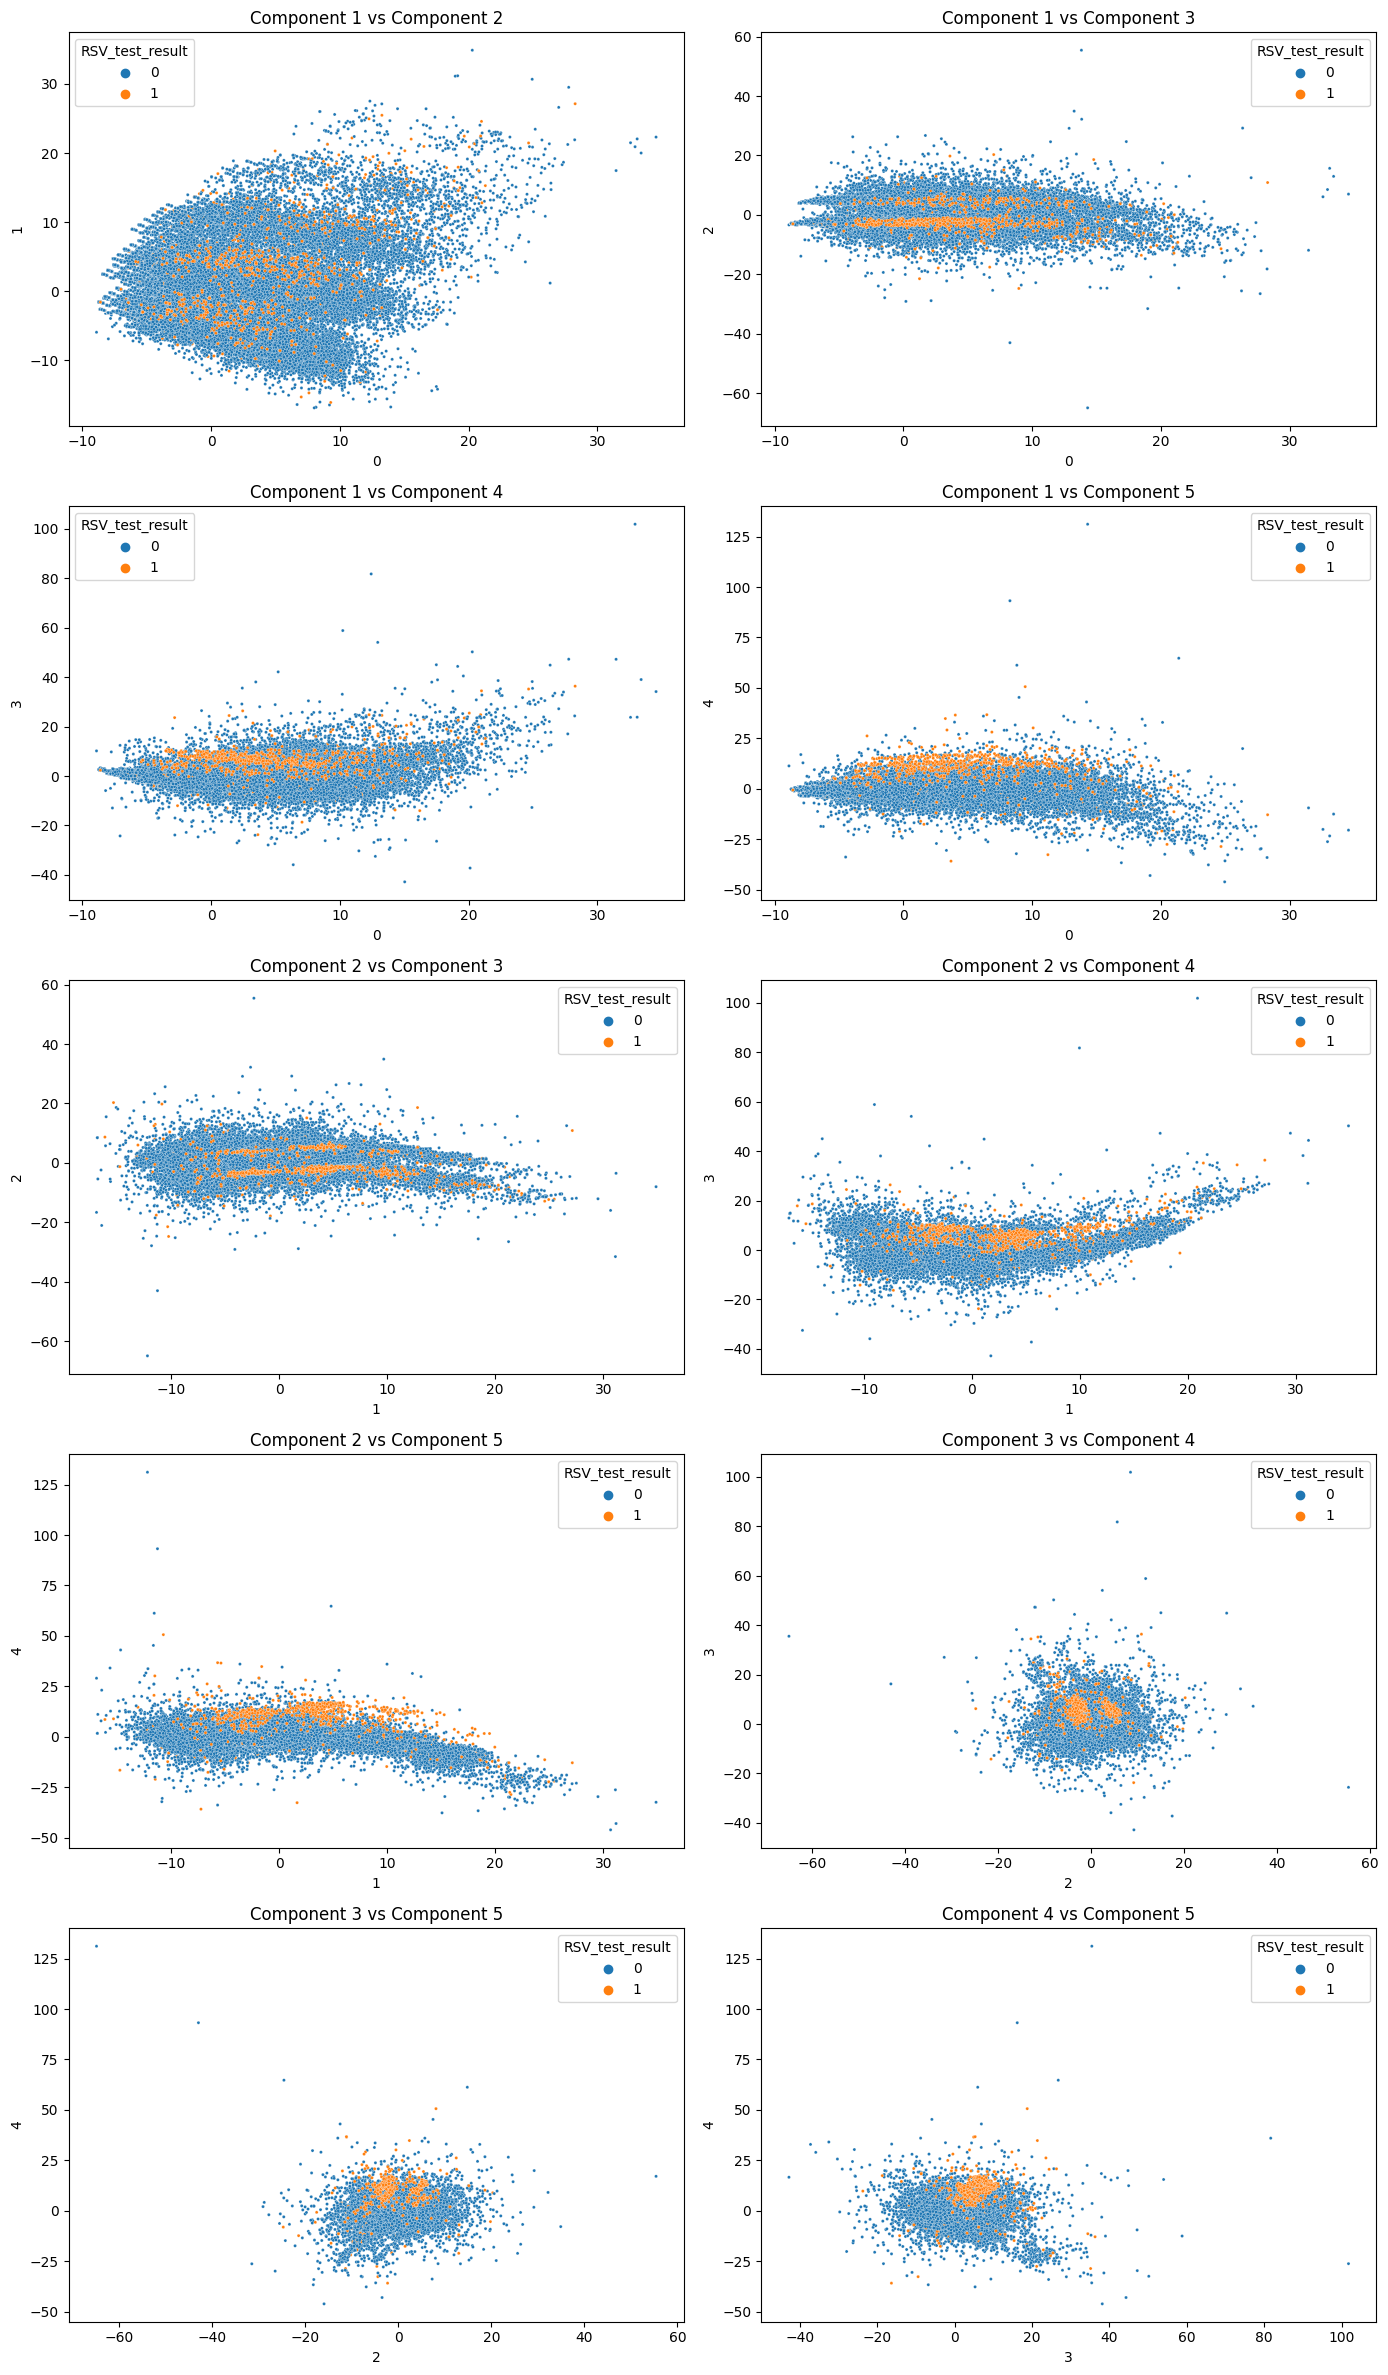

In [9]:
plot_5FMDA_planes(df=df5_visualization, hue_target = 'RSV_test_result', s_size = 5)

# 1. Build-up of a more automatic approach

In [10]:
# Validated intial process relies on three steps:
# 1. FAMD transform the data to a number of components = number of features in the data
# 2. Build-up of a ball tree 
# 3. Finding the nearest neighbour for every instance. Distance is defined structurally as the closest other instance in the tree
# 4. Determination of those instances where the closes neighbour is of the same class or not (and computation of N1 metric)

X_data = df1.drop(['RSV_test_result'], axis = 1)

# Step 1: FAMD transform
print('FAMD transforming the original data ...')

n_components = X_data.shape[1]
# n_components = 5

famd21 = prince.FAMD(n_components=n_components, random_state=random_seed)
famd21 = famd21.fit(X_data)

X_21famd = famd21.transform(X_data)

# Step 2: Ball tree 
print('Build-up of the ball tree ...')

tree = BallTree(X_21famd)

# Step 3: tree-guided closest neighbour
print('Finding closest neighbour in the ball tree for every instance ...')

# The closest point to every instance is itself, so k = 2 returns the point itself + the closest neighbour
dist, ind = tree.query(X_21famd, k=2)

# Step 4: same class neighbours
print('Determination of instances with a same-class neighbour ...')

labels = df1['RSV_test_result'].to_numpy()
same_class_neighbours = labels[ind[:, 0]] == labels[ind[:, 1]]
N1 = 1 - np.mean(same_class_neighbours)

print('Done!')

FAMD transforming the original data ...
Build-up of the ball tree ...
Finding closest neighbour in the ball tree for every instance ...
Determination of instances with a same-class neighbour ...


Having defined the initial method, there are several points of improvement.
- Famd dimensionality reduction : setting n_components to n_features may be overkilling it
- Ball tree: may be possible to build it with the original data directly, not needing to step through the famd transformation
- Extension of the N1 metric and impact in meta learning > adjust it to imbalanced settings
- Steps 1 and 3 are the bottlenecks of the process > find a way to make them faster

## Test 1: avoid FAMD analysis 

Build-up of the Ball tree using the original data directly

In [12]:
X_data = df1.drop(['RSV_test_result'], axis = 1)

# Step 0: No famd transform
print('TEST 1: Testing the process using non-famd transformed data ...')
X_data_dummies = pd.get_dummies(X_data)

# Step 2: Ball tree 
print('Build-up of the ball tree ...')

tree2 = BallTree(X_data_dummies)

# Step 3: tree-guided closest neighbour
print('Finding closest neighbour in the ball tree for every instance ...')

# The closest point to every instance is itself, so k = 2 returns the point itself + the closest neighbour
dist2, ind2 = tree2.query(X_data_dummies, k=2)

# Step 4: same class neighbours
print('Determination of instances with a same-class neighbour ...')

labels = df1['RSV_test_result'].to_numpy()
same_class_neighbours2 = labels[ind2[:, 0]] == labels[ind2[:, 1]]
N1_2 = 1 - np.mean(same_class_neighbours2)

print('Done!')

TEST 1: Testing the process using non-famd transformed data ...
Build-up of the ball tree ...
Finding closest neighbour in the ball tree for every instance ...
Determination of instances with a same-class neighbour ...
Done!


In [13]:
# The approaches identify different overlapping points
N1, N1_2

(0.043889005089590705, 0.045504194845336854)

In [45]:
# Evaluate performance of both approaches
# First: of approach 1 (yes FAMD)
print('\n------------------')
print('-------------------')
print('yes FAMD model')
model_nonOverlapping1, model_Overlapping1 = build_and_evaluate_2overlapping_models(df1 = df1, same_class_neighbors = same_class_neighbours)

# Second: of approach 2 (no FAMD)
print('\n------------------')
print('-------------------')
print('NO FAMD model')
model_nonOverlapping2, model_Overlapping2 = build_and_evaluate_2overlapping_models(df1 = df1, same_class_neighbors = same_class_neighbours2)



------------------
-------------------
yes FAMD model
----------------
Building non-overlapping model ...


Training model ... RandomForestClassifier(class_weight={'Negative': 1, 'Positive': 15},
                       random_state=42)
Best training parameters:  {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 14}
Best training f1-score:  0.6408003058243196

----------------
Performance metrics of non-overlapping model ...
Optimal threshold: 0.45
Optimal f1: 0.672514619883041


AUC Score: 0.9288630398375772
Precision / Positive predictive value: 1.0
Specificity: 1.0
Recall / sensitivity: 0.5066079295154186
Negative predictive value: 0.9931464936972219
Accuracy: 0.9931943853679286
F-1: 0.672514619883041
Precision-Recall AUC: 0.5760987839633552
----------------
Building (yes) overlapping model ...
Training model ... RandomForestClassifier(class_weight={'Negative': 1, 'Positive': 15},
                       random_state=42)
Best training parameters:  {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 14}
Best training f1-score:  0.6

Both models give similar performance, with slight differences in recall and precisionnvalues:

- Model with no FAMD: better precision (0.572 7vs 0.555)
- Model with FAMD: better recall (0.748 vs 0.705)
- Results in very similar F1 scores: (0.631 vs 0.637)